In the last post, we explore the residential energy survey data. Now, we will build linear regression models to predict annual housing unit energy consumption based on housing characteristics, household member characteristics, and usage of appliances.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
#Read the data file
data = pd.read_csv('recs2009_public.csv')

In [3]:
data.shape

(12083, 931)

### Preprocessing

The raw data contains 931 columns. These columns are a mixed of different types of data. We need to process these columns into forms that can be used in a regression model. The full dataset contains columns with values derived from models, which we will not be using. We only want to include data directly from the surveys. So, we first select the columns and  seperate them into appropriate categories. For this project, we will seperate them into data on housing, members, and appliances. The features will also be separated into categorical data (qualitative) and numerical (quantitative).

The column were separated and their names are put in a file to be read into a python dictionary. 

In [4]:
#Reading column list from a file into a dict

column_list = {}
with open('columns_list2.txt') as f:
    lines = [line.rstrip() for line in f] 
lines = filter(None, lines)

for line in lines:
    col_name, list_txt = line.strip().replace(' ','').split('=')
    column_list[col_name] = list_txt.replace('[','').replace(']','').split(',')

In [5]:
for k,v in column_list.iteritems():
    print k, len(v)

app_bin 84
house_quant 37
mem_bin 18
app_quant 46
app_qual 96
mem_qual 8
mem_quant 5
house_bin 78
house_qual 56


Some of the features contain values with a flag of -2 (not applicable). We will convert these values to zero. 

In [6]:
#Deal with N/A entries for quantitative features and binary features
def convert_na(df, col):   
    arr = df[col].values
    arr[np.where(arr == -2)] = 0
    df.loc[:,col] = arr
    return df

Next, we will need to transform the categorical data into something that can be used in a model. Each categorical columns will need to be converted to multiple columns each corresponding to a single label with values of 1/0 (one-hot encoding). We are dropping the first label for each column.

In [7]:
#Encoding Categorical data
def encode_qual(df,qual_col):
    return pd.get_dummies(df,columns=qual_col,prefix=qual_col,drop_first=True)

Put all the preprocessing steps together.

In [8]:
def preprocess(df, qual_col,quant_col,bin_col):
    df = convert_na(df,quant_col+bin_col)
    df = encode_qual(df,qual_col)
    return df

Let's also define an error used to evaluate a model. Write a function to calculate the root-mean-square error.  

In [9]:
#function for calculating error
def rms_error(y_pred,y_true):
    se = (y_pred - y_true)**2
    mse = np.mean(se)
    error =  math.sqrt(mse)
    print 'RMSE:', error
    return (se,error)
se_arr = {}
rmse = {}

It will also be useful to define a function to calculate the correlation coefficients.

In [10]:
from scipy.stats.stats import pearsonr

#Calculate and print the Pearson correlation coefficient and the coresponding p-values
def calculate_rho(df,quant_col):
    for col in quant_col:
        corcoef = pearsonr(df[col],data['KWH'])
        print "%s: %8.2f P-value: %8.2f" % (col,corcoef[0],corcoef[1])

### Benchmarking: First Linear Regression Model

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression

We start off by performing a regression using only a few main features. The columns selected are year made, number of household members, total square footage, climate region, and type of housing. 

In [12]:
#selecting columns
quant_col = ['YEARMADE','NHSLDMEM','TOTSQFT_EN']
qual_col = ['Climate_Region_Pub','TYPEHUQ']
bin_col = []

In [13]:
#create a new dataframe with these columns
df = data[quant_col+qual_col]

#preprocessing
df = preprocess(df,qual_col,quant_col,bin_col)

/Users/pear/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/pear/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
df.iloc[:3,:5]

,YEARMADE,NHSLDMEM,TOTSQFT_EN,Climate_Region_Pub_2,Climate_Region_Pub_3
0,2004,4,4675,0.0,0.0
1,1998,6,2736,0.0,0.0
2,1965,1,528,0.0,0.0


In [15]:
calculate_rho(df,quant_col)

YEARMADE:     0.21 P-value:     0.00
NHSLDMEM:     0.27 P-value:     0.00
TOTSQFT_EN:     0.38 P-value:     0.00


All the correlation coefficients are positive but not very large. All of the p-values are less than 0.01. They are all significant (using the confidence level of 0.05), which is to be expected considering the large number of samples we have.

Split the dataset into a train and a test set.

In [16]:
X = df.values
y = data['KWH'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
#Perform linear regression
clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
print 'Train set r^2:', clf.score(X_train,y_train)
print 'Test set r^2:', clf.score(X_test,y_test)

Train set r^2: 0.336684215441
Test set r^2: 0.346478847929


In [19]:
se_arr['BM_SLR'], rmse['BM_SLR'] = rms_error(clf.predict(X_test),y_test)

RMSE: 5746.03164747


That is our first benchmark with a linear regression using only 5 features. 

### Feature Selection

Since we have a lot of features and we are interested in seeing what features are important, we will perform some feature selections. There are many ways to select features. We will start with a simple univariate method by calculating feature importance for each of the feature seperately. We can then test how the linear regression does against the number of features included in the model.  

We are going to rank the features by performing a univariate statistical test using f_regression from sklearn. f_regression calculates the F-score (and the associated p-value) between the feature and the target variable. Since this is a univariate test (only using one feature at a time), it won't take into account how one feature affect any other features. This is ok since we will also be testing the regression model against the number of features.    

First, write a function to rank the features in order of importance according to the F-score. We are using SelectKBest to perform f_regression for us. 

In [20]:
from sklearn.feature_selection import SelectKBest

In [21]:
def order_features(df_train,y_train, df_test):
    #Using SelectKBest to calculate f-value and p-value for each feature (ignore the k value, we won't do a fit)
    KBest = SelectKBest(f_regression,k=100)
    KBest.fit(df_train.values,y_train)
    
    #Create a Dataframe to store KBest result
    KBest_df = pd.DataFrame(index=df_train.columns)
    KBest_df['score'] = KBest.scores_
    KBest_df['p_value'] = KBest.pvalues_
    KBest_df = KBest_df.sort_values(by='score',ascending=False)
    
    print KBest_df.head(10)
    
    #order the columns by f-score
    df_train = df_train[KBest_df.index]
    df_test = df_test[KBest_df.index]
    return df_train, df_test

Next, we test how linear regression does with numbers of features. 

In [22]:
def compare_nfeatures(df_train, y_train):
    #Compare models with k features and return train and test scores in the CV sets
    k_list = range(10,240,10) 
    train_score = []
    test_score = []

    X_train = df_train.values
    for k in k_list:
        #Need to evaluate on a CV set, so wee need to split the training set again
        X_CV_train, X_CV_test, y_CV_train, y_CV_test = train_test_split(
                    X_train[:,:k], y_train, test_size=0.3, random_state=34)
        clf = LinearRegression()
        clf.fit(X_CV_train,y_CV_train)
        train_score.append(clf.score(X_CV_train,y_CV_train))
        test_score.append(clf.score(X_CV_test,y_CV_test))
    return pd.Series(train_score,index=k_list), pd.Series(test_score,index=k_list)

Finishing feature selection by selecting the top k_best features. You can choose a method to select how many features you want. You can select a certain percentage, use a cutoff threshold, or select the number with the best test score. For now, we will select the value of k_best when including more features only improves the score by less than 0.5%. 

In [23]:
def select_features(df_train,df_test,test_score):
    for i in range(len(test_score)-5):
        if np.abs(test_score.iloc[i+5]-test_score.iloc[i]) < 0.005*test_score.iloc[i]:
            break
    k_best = test_score.index[i]
    print 'k_best:', k_best
    
    #select the top k_best features
    df_train = df_train.iloc[:,:k_best]
    df_test = df_test.iloc[:,:k_best]
    return df_train, df_test

### Modeling

#### Selecting Housing Characteristics

We are now ready to do linear regression. First, we will only include housing features.

In [24]:
qual_col = column_list['house_qual']
quant_col = column_list['house_quant']
bin_col = column_list['house_bin']

df = data[qual_col+quant_col+bin_col]
df = preprocess(df, qual_col,quant_col,bin_col)

/Users/pear/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Split the data into a train and test sets. Note that we are only interested in seeing the performance of the model. We will not use the testing error to do model selection, which would require a CV set.  

In [25]:
df_train, df_test, y_train, y_test = train_test_split(df, data['KWH'], test_size=0.2, random_state=42)

Perform feature selection and print out a list of top 10 features. 

In [26]:
df_train, df_test = order_features(df_train, y_train, df_test)
train_score, test_score = compare_nfeatures(df_train, y_train)
df_train, df_test = select_features(df_train,df_test,test_score)

                  score        p_value
TOTCSQFT    2977.889669   0.000000e+00
TOTROOMS    2252.422979   0.000000e+00
NCOMBATH    2149.771423   0.000000e+00
BEDROOMS    1991.384449   0.000000e+00
TOTHSQFT    1965.187009   0.000000e+00
TOTSQFT     1681.280228   0.000000e+00
TOTSQFT_EN  1621.664784   0.000000e+00
OTHROOMS    1355.666314  7.662338e-278
ELWATER     1284.766872  2.753209e-264
PELHOTWA_1  1212.495648  2.232746e-250
k_best: 140


Now that we have preprocessed the data and selected the features, we are ready to do regression. Since we have a large dataset (compared to the number of features), we are not overly concerned with overfitting. However, some of the features are expected to correlate. So we will perform a Ridge regression (penalized linear regression). RidgeCV method from sklearn perform Ridge regression with a built-in cross-validation for selecting the hyperparameter alpha. 

In [43]:
from sklearn.linear_model import RidgeCV

#Fitting Ridge Regression
X_train = df_train.values
X_test = df_test.values
clf = RidgeCV(normalize=True, alphas=[0.01,0.1,1,10,100])
clf.fit(df_train.values, y_train.values)
clf.score(X_test,y_test)

0.56862340497980668

Using housing features gives up a model that explains about 57% of the variance in the energy consumption data. 

In [44]:
se_arr['House_SLR'], rmse['House_SLR'] = rms_error(clf.predict(X_test),y_test)

RMSE: 4668.38299418


#### Adding household members data

Now, let's add the features on household members data into the model. These features provide information on things such as a number of household members in a housing unit, an age of the main household member, annual income, etc. 

In [45]:
qual_col = column_list['house_qual']+column_list['mem_qual']
quant_col = column_list['house_quant']+column_list['mem_quant']
bin_col = column_list['house_bin']+column_list['mem_bin']

df = data[qual_col+quant_col+bin_col]
df = preprocess(df, qual_col,quant_col,bin_col)

In [96]:
df_train, df_test, y_train, y_test = train_test_split(df, data['KWH'], test_size=0.2, random_state=42)

In [97]:
df_train, df_test = order_features(df_train, y_train, df_test)
train_score, test_score = compare_nfeatures(df_train, y_train)
df_train, df_test = select_features(df_train,df_test,test_score)

                  score        p_value
TOTCSQFT    2977.889669   0.000000e+00
TOTROOMS    2252.422979   0.000000e+00
NCOMBATH    2149.771423   0.000000e+00
BEDROOMS    1991.384449   0.000000e+00
TOTHSQFT    1965.187009   0.000000e+00
TOTSQFT     1681.280228   0.000000e+00
TOTSQFT_EN  1621.664784   0.000000e+00
OTHROOMS    1355.666314  7.662338e-278
ELWATER     1284.766872  2.753209e-264
PELHOTWA_1  1212.495648  2.232746e-250
k_best: 170


In [98]:
#Fitting Ridge Regression
X_train = df_train.values
X_test = df_test.values
clf = RidgeCV(normalize=True, alphas=[0.01,0.1,1,10,100])
clf.fit(df_train.values, y_train.values)
clf.score(X_test,y_test)

0.5909854154957257

In [99]:
se_arr['HouseMem_SLR'], rmse['HouseMem_SLR'] = rms_error(clf.predict(X_test),y_test)

RMSE: 4545.77134227


#### Adding Appliances Data

The last category of features to add is appliance usage. These features describe the number of some common appliances in a housing unit, the frequency of using them, and other characteristics. 

In [46]:
qual_col = column_list['house_qual']+column_list['mem_qual']+column_list['app_qual']
quant_col = column_list['house_quant']+column_list['mem_quant']+column_list['app_quant']
bin_col = column_list['house_bin']+column_list['mem_bin']+column_list['app_bin']

df = data[qual_col+quant_col+bin_col]
df = preprocess(df, qual_col,quant_col,bin_col)

In [47]:
df_train, df_test, y_train, y_test = train_test_split(df, data['KWH'], test_size=0.2, random_state=42)

In [48]:
df_train, df_test = order_features(df_train, y_train, df_test)
train_score, test_score = compare_nfeatures(df_train, y_train)
df_train, df_test = select_features(df_train,df_test,test_score)

                score  p_value
TOTCSQFT  2977.889669      0.0
ACROOMS   2459.774465      0.0
TOTROOMS  2252.422979      0.0
NCOMBATH  2149.771423      0.0
BEDROOMS  1991.384449      0.0
TOTHSQFT  1965.187009      0.0
HEATROOM  1870.469154      0.0
WASHLOAD  1706.033221      0.0
NUMCFAN   1704.815905      0.0
TOTSQFT   1681.280228      0.0
k_best: 140


In [49]:
#Fitting Ridge Regression
X_train = df_train.values
X_test = df_test.values
clf = RidgeCV(normalize=True, alphas=[0.01,0.1,1,10,100])
clf.fit(df_train.values, y_train.values)
clf.score(X_test,y_test)

0.63199030738745399

In [105]:
se_arr['HouseMemApp_SLR'], rmse['HouseMemApp_SLR'] = rms_error(clf.predict(X_test),y_test)

RMSE: 4313.43692289


Checking the linear assumption by plotting residuals of the top few features. 

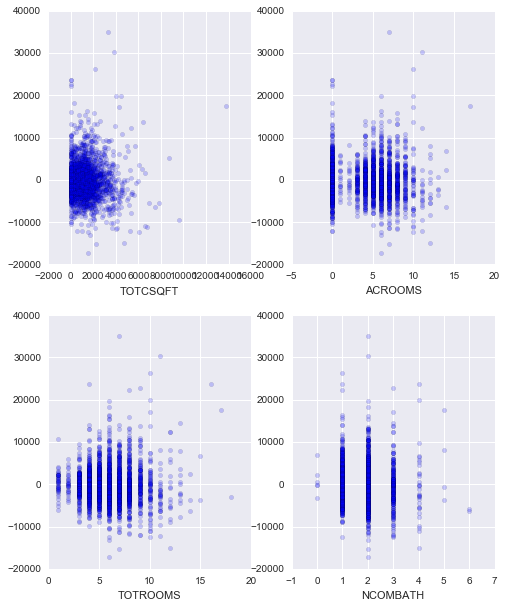

In [53]:
residual = y_test - clf.predict(X_test)

fig, axarr = plt.subplots(2,2,figsize=[8,10])
for i in range(4):
    axarr.flatten()[i].set_xlabel(df_train.columns[i])
    axarr.flatten()[i].scatter(X_test[:,i],residual,alpha=0.2)

In [68]:
df_train.iloc[:5,:15]

,TOTCSQFT,ACROOMS,TOTROOMS,NCOMBATH,BEDROOMS,TOTHSQFT,HEATROOM,WASHLOAD,NUMCFAN,TOTSQFT,TOTSQFT_EN,TVCOLOR,OTHROOMS,DRYRFUEL_5,ELWATER
4807,1688.0,7.0,7.0,2.0,5.0,1688.0,7.0,3.0,4.0,2088.0,1688.0,2.0,2.0,1.0,0.0
6973,911.0,4.0,7.0,2.0,2.0,2149.0,7.0,3.0,1.0,2549.0,2149.0,2.0,5.0,0.0,0.0
8672,0.0,0.0,4.0,1.0,1.0,617.0,4.0,2.0,0.0,617.0,617.0,2.0,3.0,1.0,1.0
5071,0.0,0.0,9.0,3.0,4.0,2100.0,6.0,3.0,1.0,4582.0,4582.0,1.0,5.0,1.0,0.0
10979,3650.0,10.0,10.0,2.0,3.0,3650.0,10.0,3.0,4.0,4050.0,3650.0,3.0,7.0,1.0,0.0


### Other Models